In [23]:
from res_result import *
import numpy as np
import pandas as pd
sns.set(style='whitegrid')
%pylab inline
path = 'res/count_k1000000_10000000_1.5/' #stream has distinct keys = 227792

Populating the interactive namespace from numpy and matplotlib


/home/ch/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'plot']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [194]:
# see data
!wc /mnt/data1/zipf/count_k1000000_10000000_1.5
!wc /mnt/data1/zipf/stream_k1000000_10000000_1.5

1000000 2000000 8895910 /mnt/data1/zipf/count_k1000000_10000000_1.5
10000000 10000000 23434030 /mnt/data1/zipf/stream_k1000000_10000000_1.5


In [24]:
cal_depth(0.99)

4.605170185988091

In [25]:
#limit additive error=8. stream size = 10**7
epsilon = 8/(10**7)
w = np.e / epsilon
print("if row is fixed to 4, width is", w/4, "total memory is", w*5)

if row is fixed to 4, width is 849463.0713934517 total memory is 16989261.427869033


## Fix memory=16988160, investigate rows. adaptive rows = memory/5/width

In [33]:
r_rows = pd.DataFrame()
c = 0
for dirpath, dirnames, filenames in os.walk(path):
    print("has {} files".format(len(filenames)))
    for f in filenames:
        w, d, rows, t, T = f.split('_')
        #print(t, d, T)
        if T[:3]=='169' and t=='0' and d=='5':
            w, d, rows, t, T = f.split('_')
            #plot_topk('res/'+f, small_w=int(w), depth=int(d), layers=int(rows), topk=1000)
            r_rows = r_rows.append(read_res_row(f, path))
            print(c, f)
            c+= 1
    break

has 100 files
0 3318_5_1024_0_16988160
1 106182_5_32_0_16989120
2 212365_5_16_0_16989200
3 424731_5_8_0_16989240
4 377539_5_9_0_16989255
5 679570_5_5_0_16989250
6 1698926_5_2_0_16989260
7 26545_5_128_0_16988800
8 566308_5_6_0_16989240
9 1132617_5_3_0_16989255
10 53091_5_64_0_16989120
11 339785_5_10_0_16989250
12 485407_5_7_0_16989245
13 6636_5_512_0_16988160
14 3397853_5_1_0_16989265
15 13272_5_256_0_16988160
16 849463_5_4_0_16989260


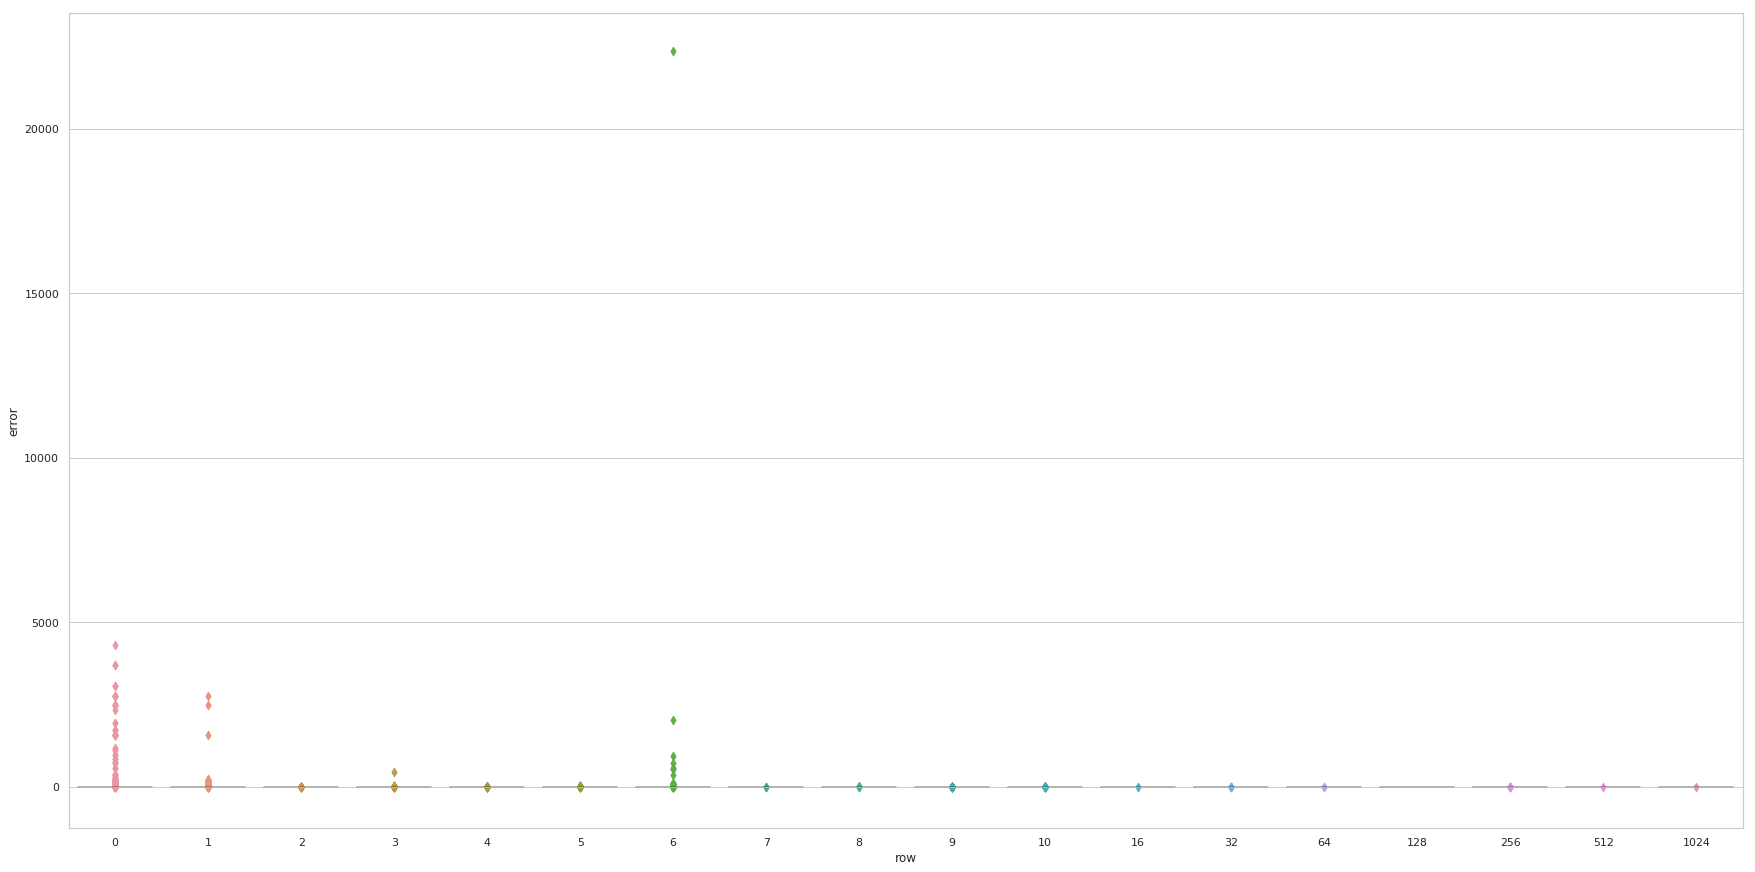

In [75]:
plt.figure(figsize=[30,15])
sns.boxenplot(x='row', y='error', data=r_rows, outlier_prop=0.01)

#plt.ylim([-1,10])

In [32]:
# mean errors:
errs = r_rows.groupby('row').mean()
errs.sort_values(by='error')

,error
row,
128,0.000000
1024,0.000002
16,0.000002
512,0.000002
64,0.000003
7,0.000005
32,0.000007
256,0.000015
8,0.000053


In [82]:
#counts of out of bound estimates::adding one dimension increases possibility --> from the extra hash?
r_rows[r_rows.error>8].groupby('row').error.count().sort_values()

row
8        1
2        3
4        4
10       6
6       19
3       29
5       38
1      232
0     2728
Name: error, dtype: int64

In [109]:
def read_res_row_topk(f, k, p):
    adaptives = []
    big_cmss = []
    cmss = []
    true_counts=[]
    width, depth, row, threshold, memory = list(map(int, f.split('_')))
    small_w = width
    with open(p+f, 'r') as f:
        res = f.readlines()

    for l in res:
        adaptive, big_cms, cms, true_count = l.split(',')
        adaptives.append(float(adaptive))
        big_cmss.append(float(big_cms))
        cmss.append(float(cms))
        true_counts.append(int(true_count))

    d = pd.DataFrame(columns=[
                              'adaptives',
                              'big_cms',
                              'cms',
                              'true_count'])

    d.adaptives = adaptives
    d.big_cms = big_cmss
    d.cms = cmss
    d.true_count = true_counts
    tc = d.true_count
    
    d = d.sort_values('true_count', ascending=False).reset_index(drop=True)
    d = d.loc[:(k*10)]
        
    d_err = pd.DataFrame(columns=['width', 'height', 'row', 'threshold', 'error'])
    t = pd.DataFrame(list(map(lambda x: [width, depth, row, threshold, x], d.adaptives)), 
                     columns=['width', 'height', 'row', 'threshold', 'error' ])

    d_err = d_err.append(t)
    t = pd.DataFrame(list(map(lambda x: [width, depth, 0,  threshold, x], d.big_cms)), 
                     columns=['width', 'height', 'row', 'threshold', 'error' ])
    d_err = d_err.append(t)
    return d_err

In [111]:
#see the top10 item error
r_rows_top = {}
for i in range(10):
    k = (i+1)*10
    r_rows_top[k] = pd.DataFrame()
c = 0
for dirpath, dirnames, filenames in os.walk(path):
    print("has {} files".format(len(filenames)))
    for f in filenames:
        w, d, rows, t, T = f.split('_')
        if T[:3]=='169' and t=='0' and d=='5':
            w, d, rows, t, T = f.split('_')
            #plot_topk('res/'+f, small_w=int(w), depth=int(d), layers=int(rows), topk=1000)
            for i in range(10):
                k = (i+1)*10
                dd = read_res_row_topk(f, k, path)
                r_rows_top[k] = r_rows_top[k].append(dd)
                #print(r_rows_top[k].head())
            #print(c, f)
            c+= 1
    break

has 100 files


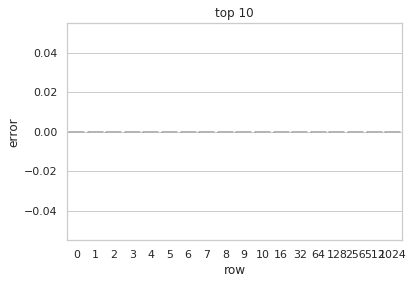

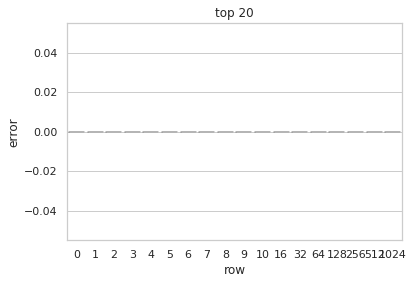

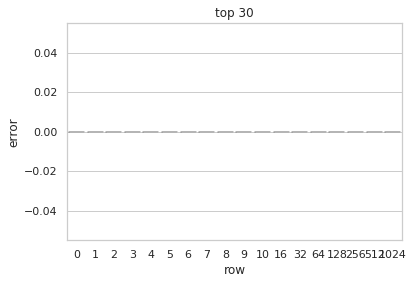

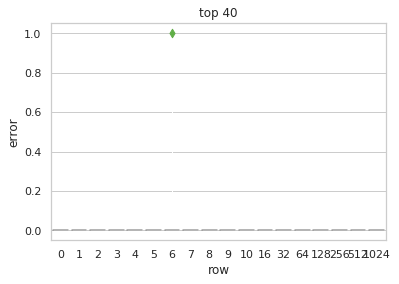

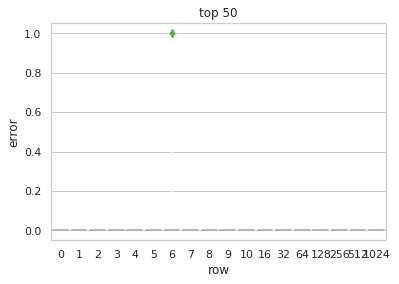

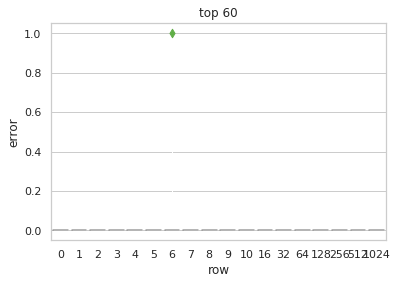

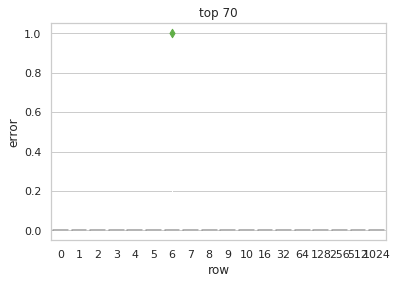

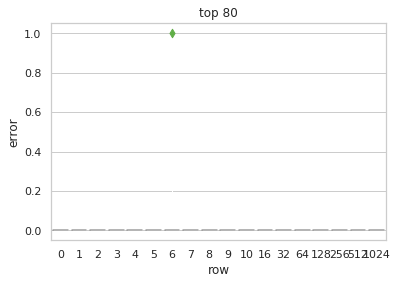

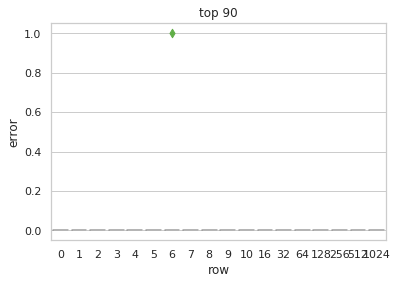

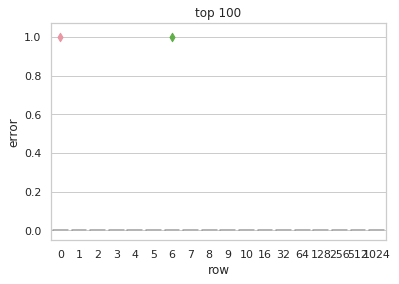

In [128]:
for i in range(10):
    k = (i+1)*10
    plt.figure()
    plt.title('top {}'.format((i+1)*10))
    sns.boxenplot(x="row", y="error", data=r_rows_top[k])

## experiment over threshold. 
Fix adaptive CMS configure: width=212365, height=5, row=16; Big CMS configure: width = 212365*16, height=5  

In [191]:
r_threshold = pd.DataFrame()
c = 0
for dirpath, dirnames, filenames in os.walk(path):
    #print("has {} files".format(len(filenames)))
    for f in filenames:
        w, d, rows, t, T = f.split('_')
        if (w=='212365') and (d=='5') and (rows=='16'):
            #plot_topk('res/'+f, small_w=int(w), depth=int(d), layers=int(rows), topk=1000)
            r_threshold = r_threshold.append(read_res_row(f, path))
            print(c, f)
            c+= 1
        else:
            continue
    break  

0 212365_5_16_2097152_16989200
1 212365_5_16_8192_16989200
2 212365_5_16_16777216_16989200
3 212365_5_16_65536_16989200
4 212365_5_16_512_16989200
5 212365_5_16_0_16989200
6 212365_5_16_2_16989200
7 212365_5_16_16_16989200
8 212365_5_16_536870912_16989200
9 212365_5_16_1024_16989200
10 212365_5_16_4_16989200
11 212365_5_16_16384_16989200
12 212365_5_16_256_16989200
22 212365_5_16_131072_16989200
23 212365_5_16_268435456_16989200
24 212365_5_16_2048_16989200
25 212365_5_16_134217728_16989200
26 212365_5_16_4194304_16989200
27 212365_5_16_1073741824_16989200
28 212365_5_16_128_16989200
29 212365_5_16_1048576_16989200
30 212365_5_16_8_16989200
31 212365_5_16_1_16989200


In [195]:
with open('res/exp_threshold_capacity_time', 'r') as f:
    c = f.readlines()
li=1
capacity = []
a_time = []
b_time = []
thresholds = []

i=0
while i < len(c)-7:
    thresholds.append(int(c[i+1].split('/')[2].split('_')[-2]))
    #print(c[i+5].split(' ')[-1])
    capacity.append(float(c[i+5].split(' ')[-1]))
    a_time.append(float(c[i+6].split('time')[-1]))
    b_time.append(float(c[i+7].split('time')[-1]))
    i += 8
#print(capacity)

Text(0.5, 0, 'threshold')

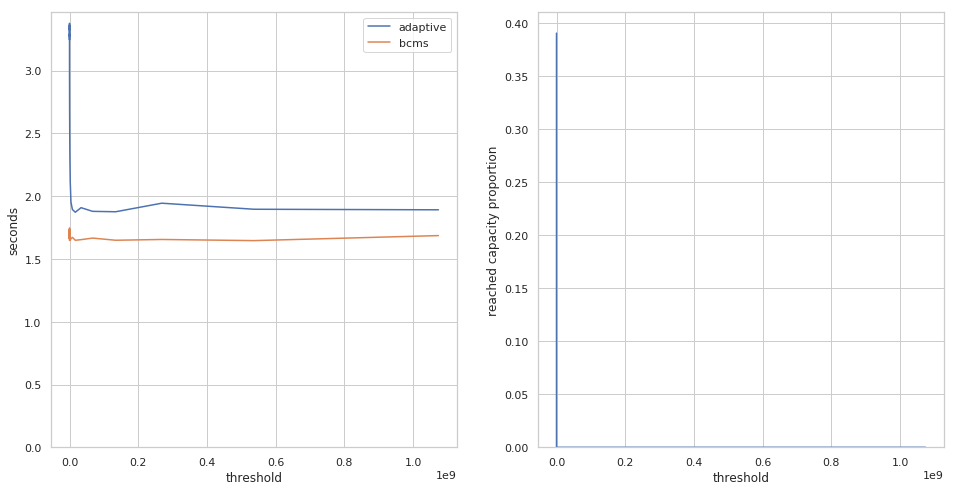

In [207]:
l = len(a_time)
plt.figure(figsize=[16,8])
plt.subplot(121)
plt.plot(thresholds[21:], a_time[21:], label='adaptive')
plt.plot(thresholds[21:], b_time[21:], label='bcms')
plt.ylim(0,)
plt.ylabel('seconds')
plt.xlabel('threshold')
plt.legend()

plt.subplot(122)
plt.plot(thresholds[21:], capacity[21:])
plt.ylim(0,)
plt.ylabel('reached capacity proportion')
plt.xlabel('threshold')

In [208]:
print('capacity reached', capacity[:])

capacity reached [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.998047, 0.951074, 0.835254, 0.585547, 0.29248, 0.125391, 0.0549805, 0.0212891, 0.00830078, 0.00449219, 0.00224609, 0.0, 0.0, 0.0, 0.390799, 0.257896, 0.165532, 0.10579, 0.0664918, 0.0425338, 0.0266655, 0.0169812, 0.0105169, 0.00668616, 0.004118, 0.0026146, 0.00164617, 0.00103724, 0.00063817, 0.000397351, 0.00025802, 0.000154812, 8.60067e-05, 5.1604e-05, 3.44027e-05, 1.72013e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [209]:
m = r_threshold.groupby('threshold').mean()
print('mean error is')
m.sort_values(by='error')

mean error is


,error
threshold,
0,0.007573
1,0.012663
2,0.017800
4,0.023116
8,0.028953
16,0.034919
32,0.041002
64,0.048728
128,0.057552


(0, 1000)

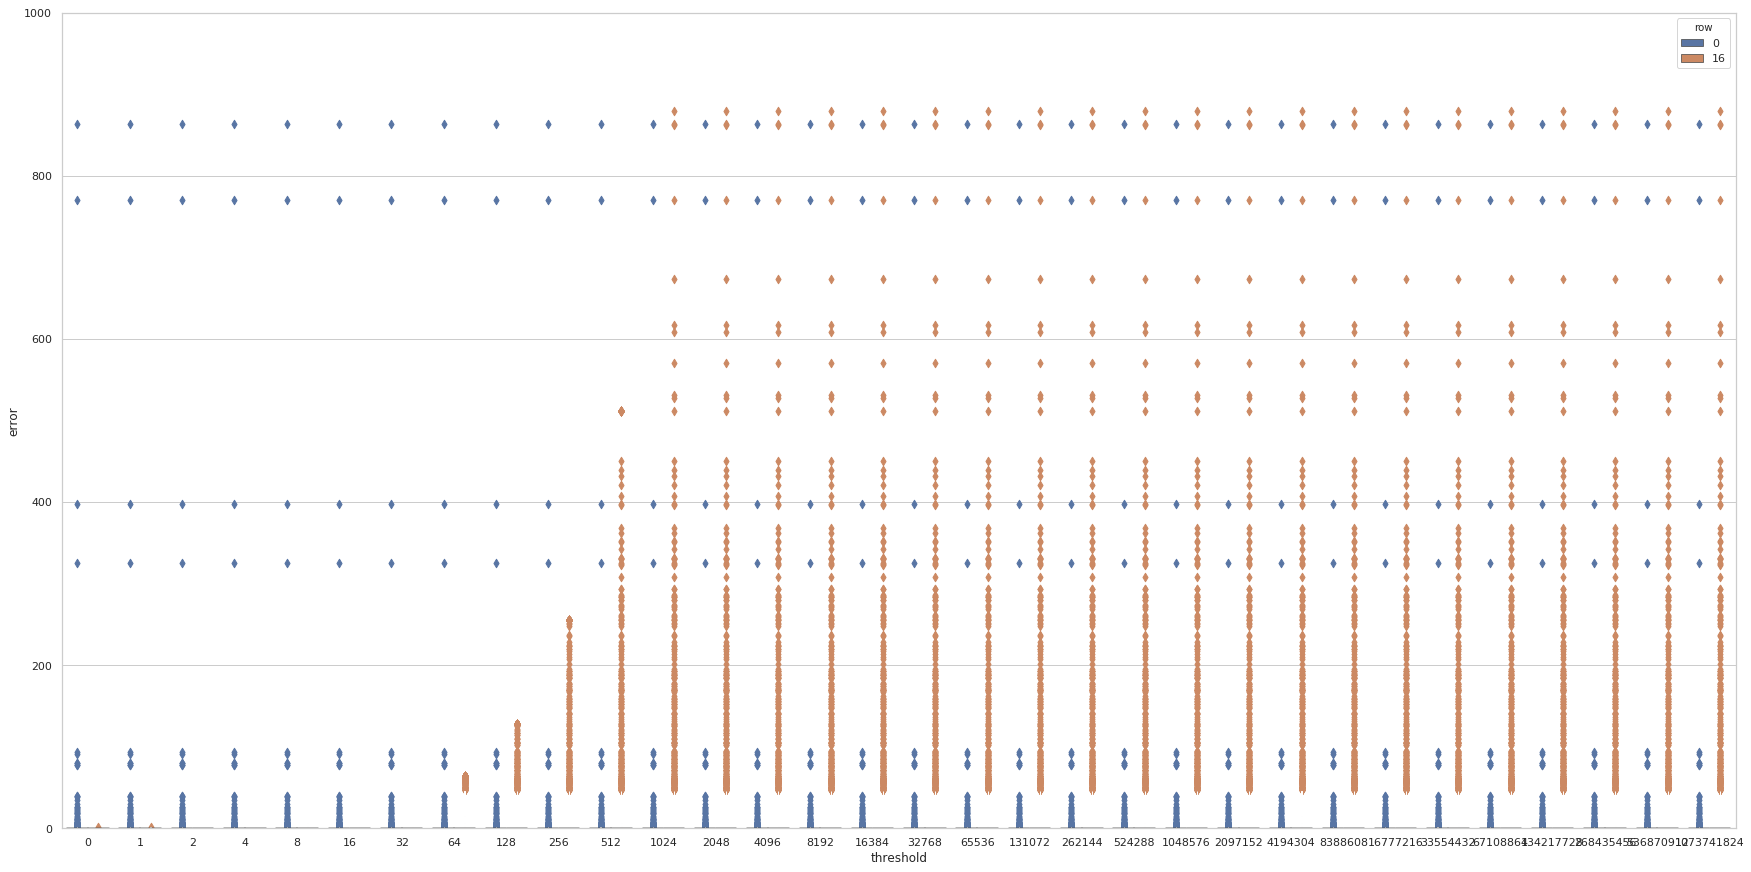

In [201]:
plt.figure(figsize=[30,15])
sns.boxenplot(x='threshold', y='error',hue='row', data=r_threshold)
plt.ylim([0,1000])

In [180]:
k=10
r_threshold_topk = {}
for i in range(10):
    r_threshold_topk[(i+1) * 10] = pd.DataFrame()
c = 0
for dirpath, dirnames, filenames in os.walk(path):
    print("has {} files".format(len(filenames)))
    for f in filenames:
        w, d, rows, t, T = f.split('_')
        if (int(w)==212365) and (int(d)==5) and (int(rows)==16):
            for k in range(10):
                
            #plot_topk('res/'+f, small_w=int(w), depth=int(d), layers=int(rows), topk=1000)
                r_threshold_topk[(k+1)*10] = r_threshold_topk[(k+1) * 10].append(read_res_row_topk(f, (k+1)*10, path))
            print(c, f)
            c+= 1
        else:
            continue
    break

has 124 files
0 212365_5_16_2097152_16989200
1 212365_5_16_8192_16989200
2 212365_5_16_65536_16989200
3 212365_5_16_512_16989200
4 212365_5_16_0_16989200
5 212365_5_16_2_16989200
6 212365_5_16_16_16989200
7 212365_5_16_1024_16989200
8 212365_5_16_4_16989200
9 212365_5_16_16384_16989200
10 212365_5_16_256_16989200
11 212365_5_16_262144_16989200
12 212365_5_16_524288_16989200
13 212365_5_16_8388608_16989200
14 212365_5_16_64_16989200
15 212365_5_16_32768_16989200
16 212365_5_16_4096_16989200
17 212365_5_16_32_16989200
18 212365_5_16_131072_16989200
19 212365_5_16_2048_16989200
20 212365_5_16_4194304_16989200
21 212365_5_16_128_16989200
22 212365_5_16_1048576_16989200
23 212365_5_16_8_16989200
24 212365_5_16_1_16989200


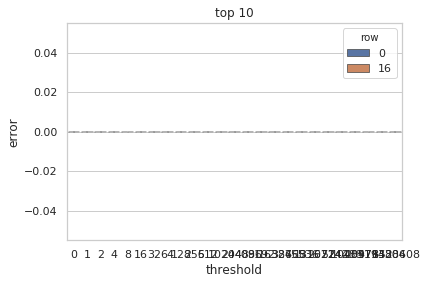

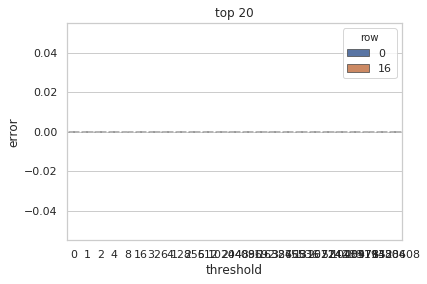

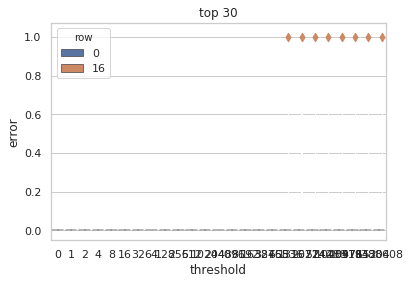

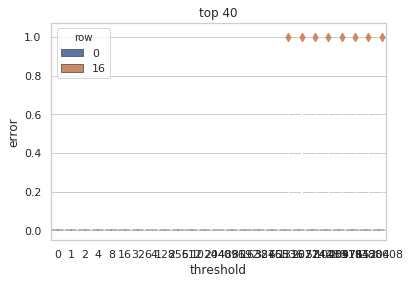

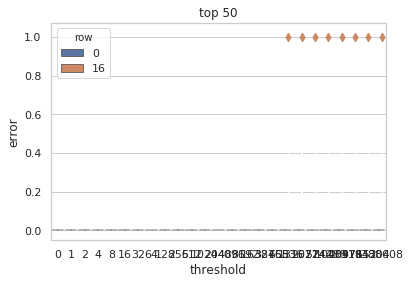

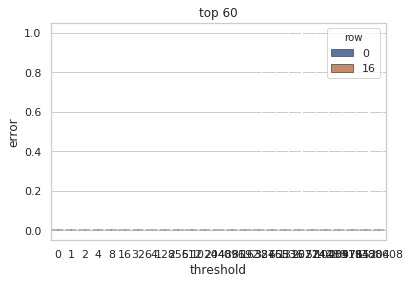

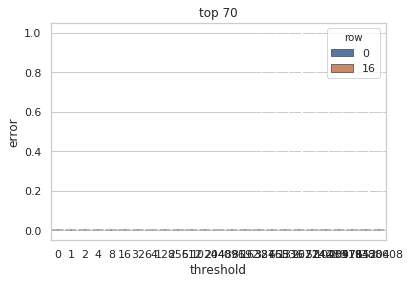

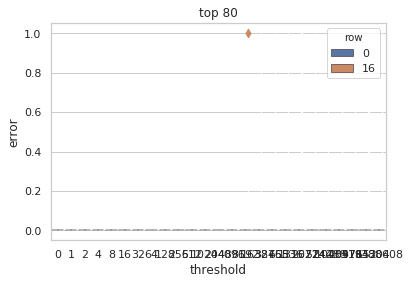

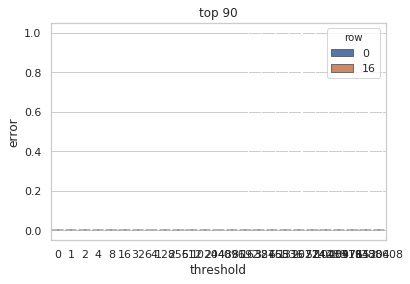

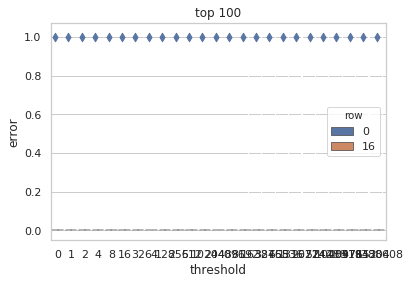

In [186]:
for i in range(10):
    plt.figure()
    plt.title('top {}'.format((i+1)*10))
    sns.boxenplot(x="threshold", y="error", hue='row', data=r_threshold_topk[(i+1)*10])